In [120]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## Data Exploration

In [121]:
# Load data
df = pd.read_csv('./dataset/btceUSD_1-min_data_2012-01-01_to_2017-05-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325292180,4.247,4.247,4.247,4.247,0.4,1.6988,4.247
1,1325292240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325292300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325292360,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325292420,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

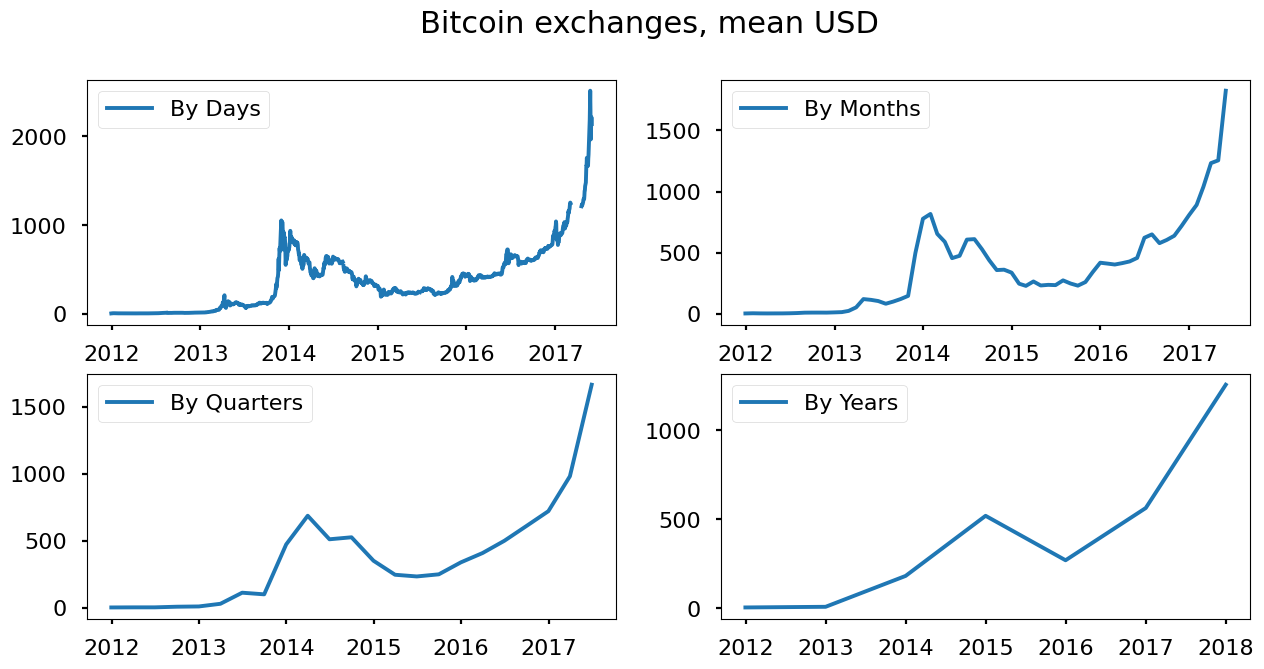

In [123]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

predicting the bitcoin prices by months.

## Stationarity check and Seasonal and Trend decomposition of the series

<Figure size 1000x700 with 0 Axes>

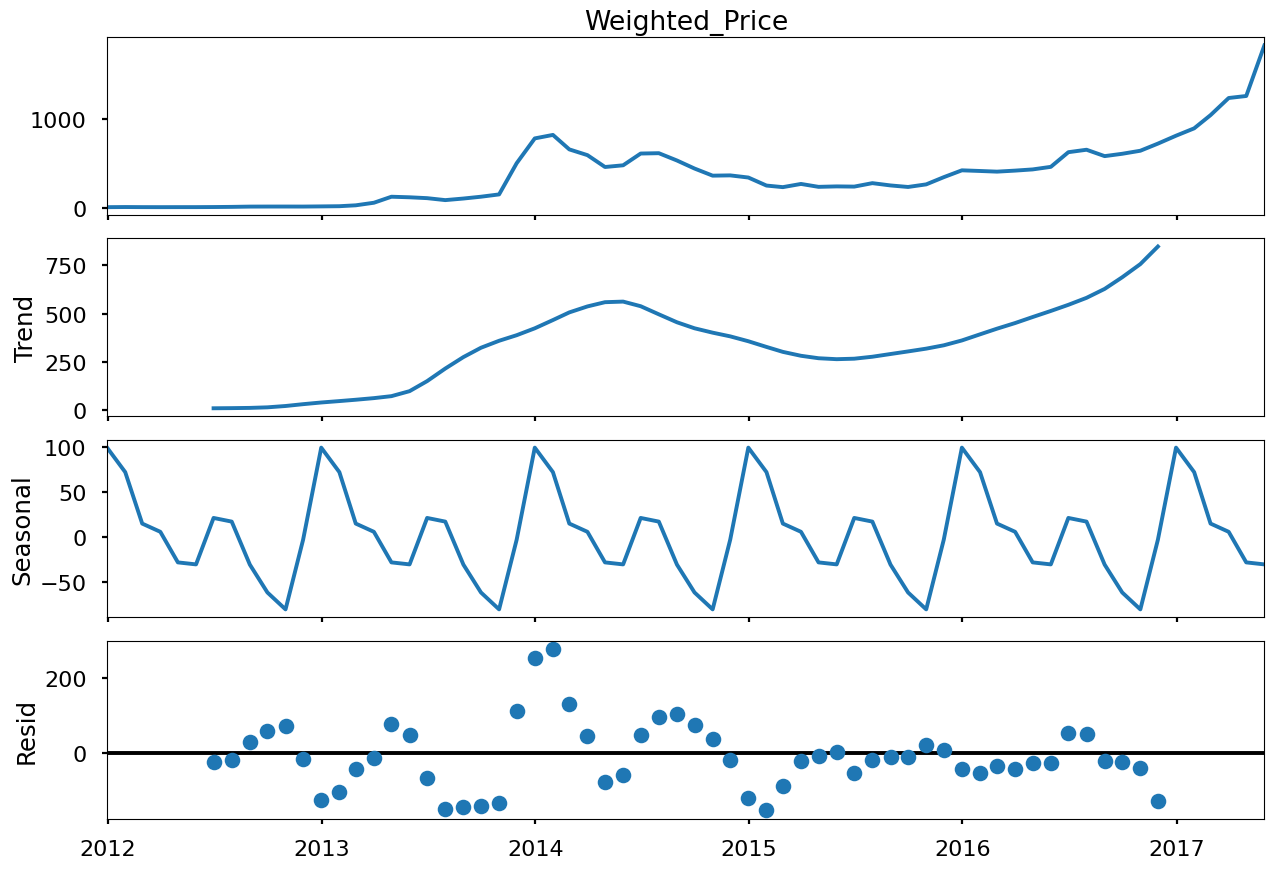

In [124]:
plt.figure(figsize=[10,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
plt.show()

## Box-Cox Transformations

In [125]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1]

0.9977602517452038

In [126]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

price_series = df_month.Weighted_Price_box

# Perform ADF test
adf_test = adfuller(price_series, autolag="AIC")

# Interpret the results
print("ADF statistic:", adfuller(price_series, autolag="AIC")[0])
print("p-value:", adfuller(price_series, autolag="AIC")[1])

# Stationarity decision
if adf_test[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

# Optional: Print critical values for comparison
print("Critical values:")
for key, value in adfuller(price_series, autolag="AIC")[4].items():
    print(f"{key}: {value}")


ADF statistic: -0.41928922985599937
p-value: 0.9068280090564168
Data is not stationary
Critical values:
1%: -3.53692771987915
5%: -2.907887369384766
10%: -2.591493291015625


# The series is not Stationary

## Seasonal differentiation

In [127]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
p = sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1]
print("Dicky Fuller Test = ",p)
if p > 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")


Dicky Fuller Test =  0.13724019607299798
Data is stationary


## Regular differentiation

Dickey-Fuller test: p=0.014538


<Figure size 1500x700 with 0 Axes>

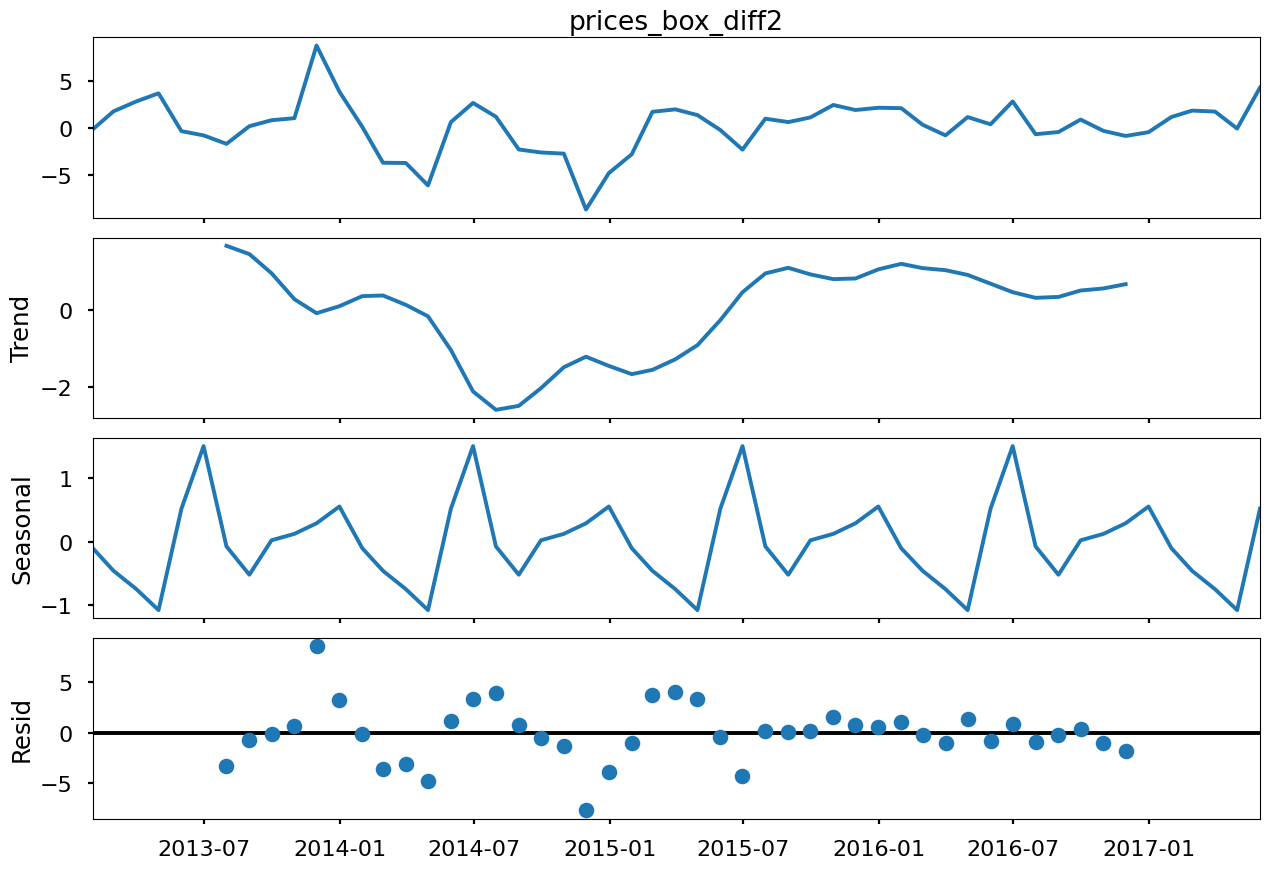

In [128]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

# The series is stationary.

# The series is seasonal

# PLotting ACF and PACF plots

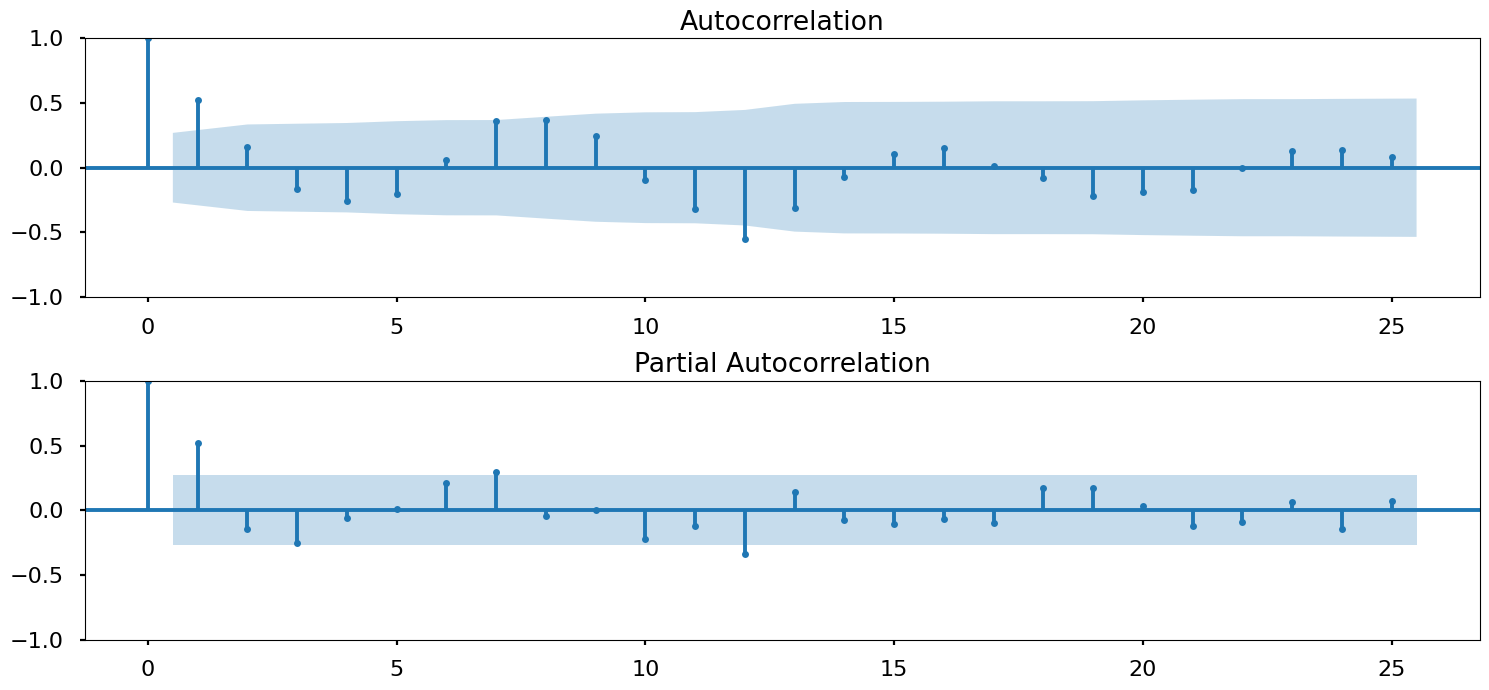

In [129]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=25, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=25, ax=ax)
plt.tight_layout()
plt.show()

# ARIMA Model  

In [130]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 3, 0, 1  # Replace with your chosen values

# Fit ARIMA model
model_1 = ARIMA(df_month.Weighted_Price_box, order=(p, d, q)).fit()

print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:     Weighted_Price_box   No. Observations:                   66
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -125.954
Date:                Thu, 07 Dec 2023   AIC                            263.909
Time:                        13:37:08   BIC                            277.047
Sample:                    12-31-2011   HQIC                           269.100
                         - 05-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.2736     13.309      1.448      0.148      -6.811      45.359
ar.L1          1.6305      1.483      1.099      0.272      -1.276       4.537
ar.L2         -0.8106      2.120     -0.382      0.7

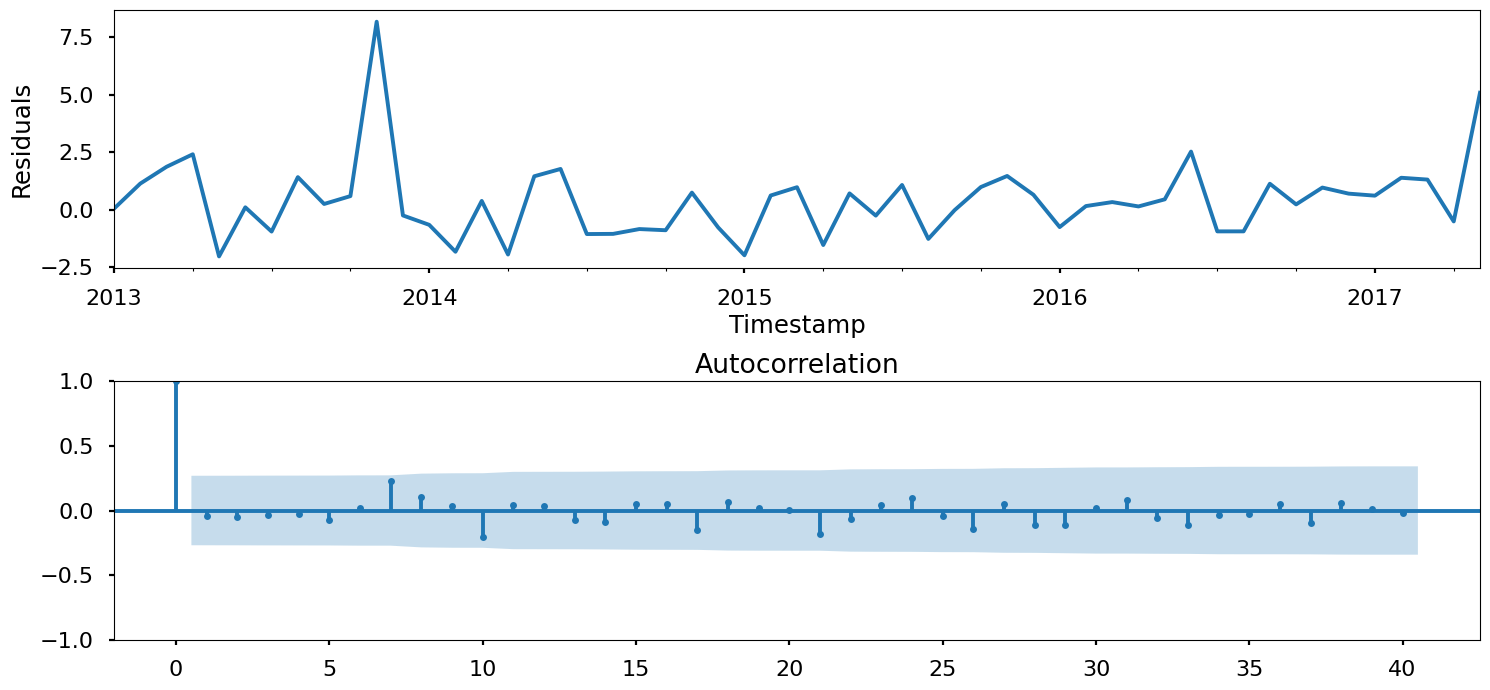

In [131]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
model_1.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model_1.resid[13:].values.squeeze(), lags=40, ax=ax)

plt.tight_layout()
plt.show()

In [132]:
# To normalize the data
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

# SARIMA Model

In [133]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 4, 0, 1
P, D, Q, s = 3, 0, 1, 7 

# Fit SARIMA model
model_2 = SARIMAX(df_month.Weighted_Price_box, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

print(model_2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                Weighted_Price_box   No. Observations:                   66
Model:             SARIMAX(4, 0, 1)x(3, 0, 1, 7)   Log Likelihood                -122.317
Date:                           Thu, 07 Dec 2023   AIC                            264.634
Time:                                   13:37:09   BIC                            286.531
Sample:                               12-31-2011   HQIC                           273.287
                                    - 05-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4785      0.475      1.008      0.314      -0.452       1.409
ar.L2          0.9157      0.622      1.473

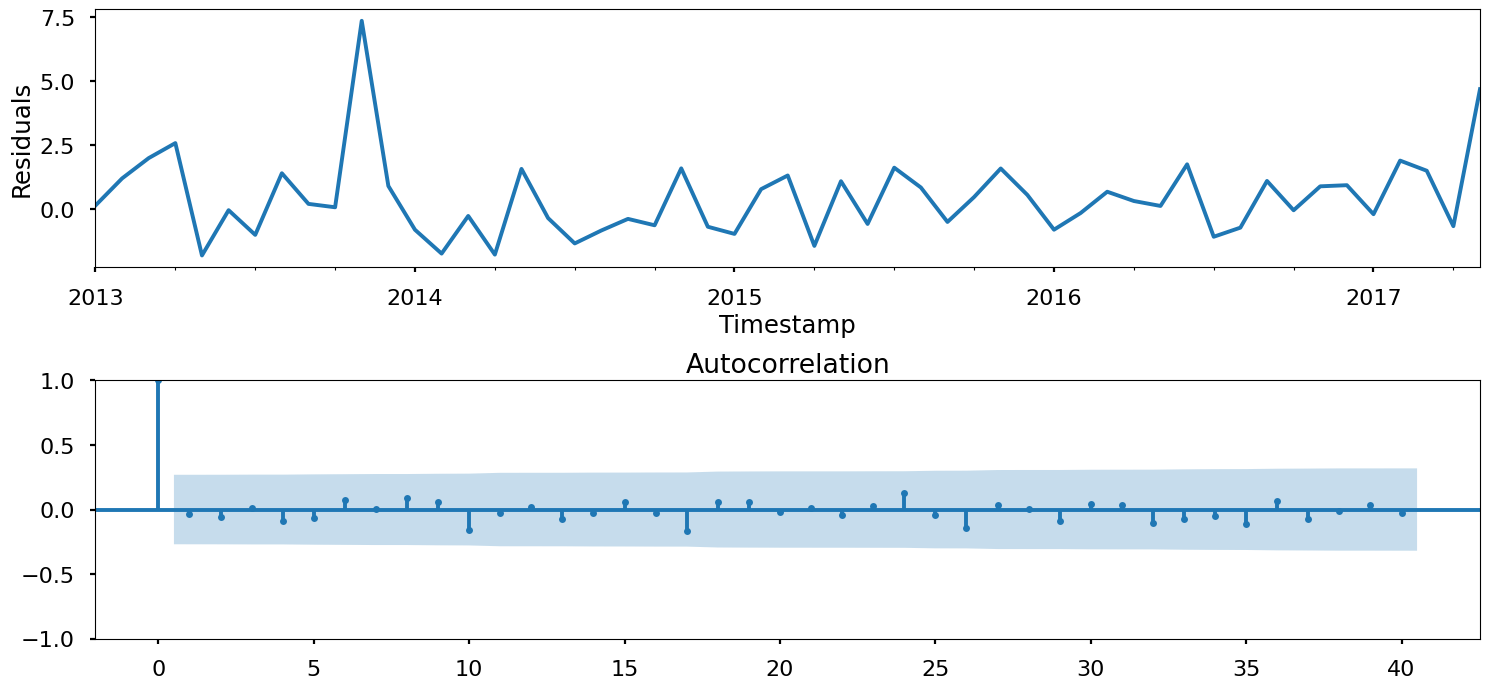

In [134]:
plt.figure(figsize=(15,7))
plt.subplot(211)
model_2.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model_2.resid[13:].values.squeeze(), lags=40, ax=ax)

plt.tight_layout()
plt.show()

In [135]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

actual_prices = df_month.Weighted_Price_box

p, d, q = 2, 0, 1
P, D, Q, s = 1, 0, 1, 7

arima_model = ARIMA(actual_prices, order=(p, d, q)).fit()
sarima_model = SARIMAX(actual_prices, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()

arima_predictions = arima_model.predict(start="2012-1-31", end="2017-5-31")
sarima_predictions = sarima_model.predict(start="2012-1-31", end="2017-5-31")


In [136]:

import numpy as np
from sklearn.metrics import r2_score

arima_mse = mean_squared_error(actual_prices[arima_predictions.index], arima_predictions)
arima_mae = mean_absolute_error(actual_prices[arima_predictions.index], arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_r2score = r2_score(actual_prices[arima_predictions.index], arima_predictions) 

sarima_mse = mean_squared_error(actual_prices[sarima_predictions.index], sarima_predictions)
sarima_mae = mean_absolute_error(actual_prices[sarima_predictions.index], sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_r2score = r2_score(actual_prices[sarima_predictions.index], sarima_predictions) 


# Print the results
print("ARIMA MSE:", arima_mse)
print("ARIMA MAE:", arima_mae)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA R2-Score:", arima_r2score)
print("-------------------------------------")
print("SARIMA MSE:", sarima_mse)
print("SARIMA MAE:", sarima_mae)
print("SARIMA RMSE:", sarima_rmse)
print("SARIMA R2-Score:", sarima_r2score)


ARIMA MSE: 2.465520923530182
ARIMA MAE: 1.0065985163945734
ARIMA RMSE: 1.5701977338953785
ARIMA R2-Score: 0.9681006419261099
-------------------------------------
SARIMA MSE: 2.2594680664976314
SARIMA MAE: 0.9892390094100454
SARIMA RMSE: 1.5031527089745844
SARIMA R2-Score: 0.970766591261968


# Lower MSE and MAE score indicates better predictions

# Hence SARIMA model is the best model for this particular dataset and for getting the best predictions and forecasts.

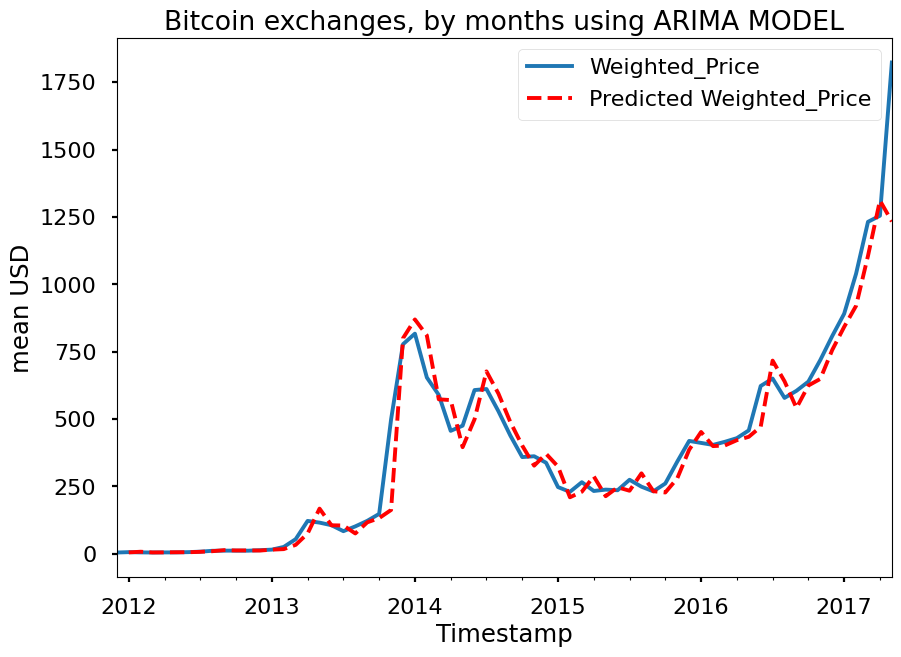

In [137]:
df_month2 = df_month[['Weighted_Price']]
df_month2['forecast'] = invboxcox(arima_predictions,lmbda)
plt.figure(figsize=(10,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months using ARIMA MODEL')
plt.ylabel('mean USD')
plt.show()

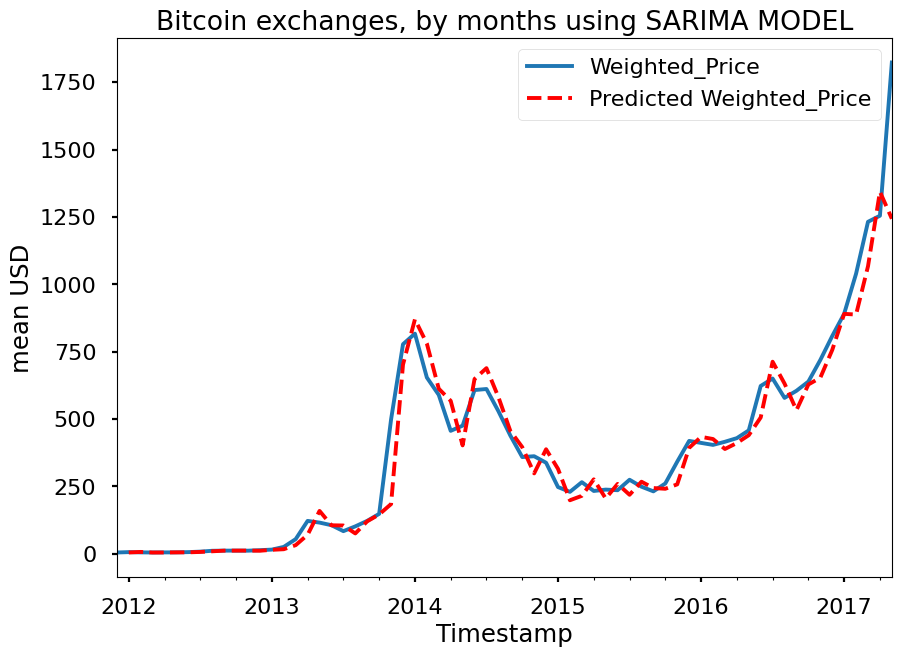

In [138]:
df_month2 = df_month[['Weighted_Price']]
df_month2['forecast'] = invboxcox(sarima_predictions,lmbda)
plt.figure(figsize=(10,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months using SARIMA MODEL')
plt.ylabel('mean USD')
plt.show()

# GARCH Model

In [139]:
import pandas as pd
from arch import arch_model

model = arch_model(df_month.Weighted_Price_box, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
model_fit = model.fit()

# Extract volatility forecasts (adjust horizon as needed)
vol_forecasts = model_fit.forecast(horizon=10)

# Calculate and analyze conditional volatility
conditional_volatility = model_fit.conditional_volatility


Iteration:      1,   Func. Count:      5,   Neg. LLF: 265.54872324019766
Iteration:      2,   Func. Count:      9,   Neg. LLF: 265.5185615813907
Iteration:      3,   Func. Count:     13,   Neg. LLF: 265.3710152189884
Iteration:      4,   Func. Count:     17,   Neg. LLF: 264.8477616369757
Iteration:      5,   Func. Count:     21,   Neg. LLF: 264.9565419575893
Iteration:      6,   Func. Count:     26,   Neg. LLF: 264.856931713622
Iteration:      7,   Func. Count:     31,   Neg. LLF: 264.8370453212267
Iteration:      8,   Func. Count:     34,   Neg. LLF: 264.83704528681733
Optimization terminated successfully    (Exit mode 0)
            Current function value: 264.8370453212267
            Iterations: 8
            Function evaluations: 34
            Gradient evaluations: 8


In [140]:
print(model_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:     Weighted_Price_box   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.015
Vol Model:                      GARCH   Log-Likelihood:               -264.837
Distribution:                  Normal   AIC:                           535.674
Method:            Maximum Likelihood   BIC:                           542.243
                                        No. Observations:                   66
Date:                Thu, Dec 07 2023   Df Residuals:                       66
Time:                        13:37:10   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          1.2093      0.696      1.737  8.244e-02 

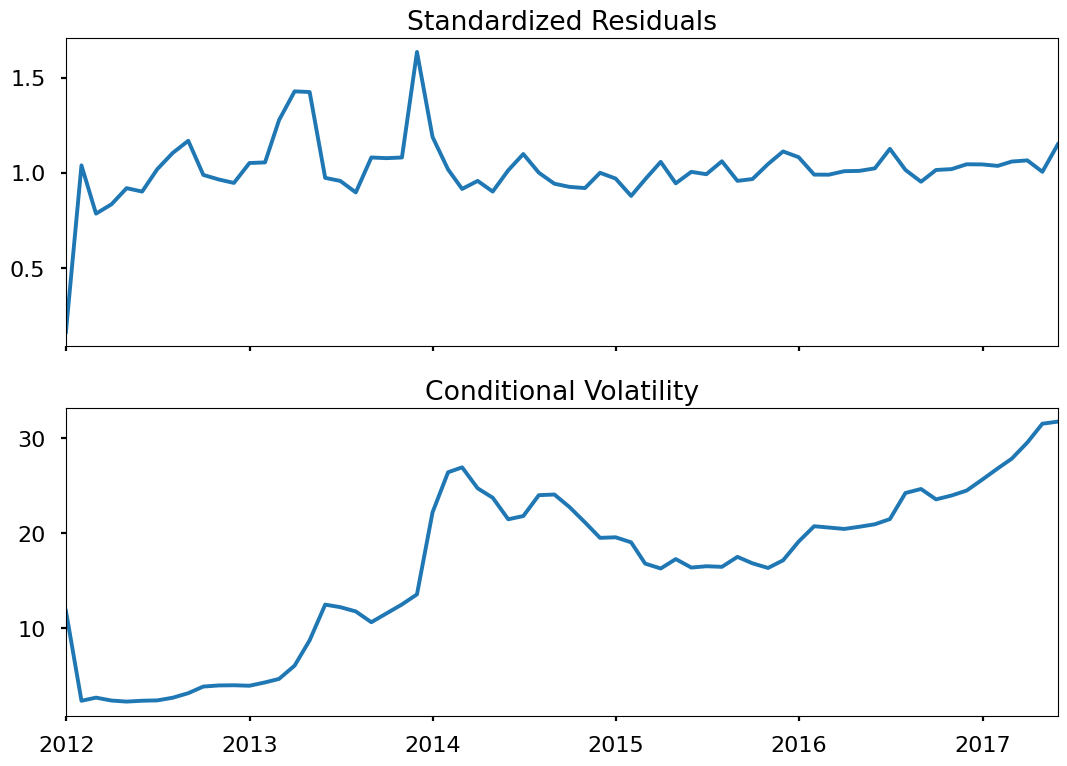

In [141]:
model_fit.plot()
plt.show()